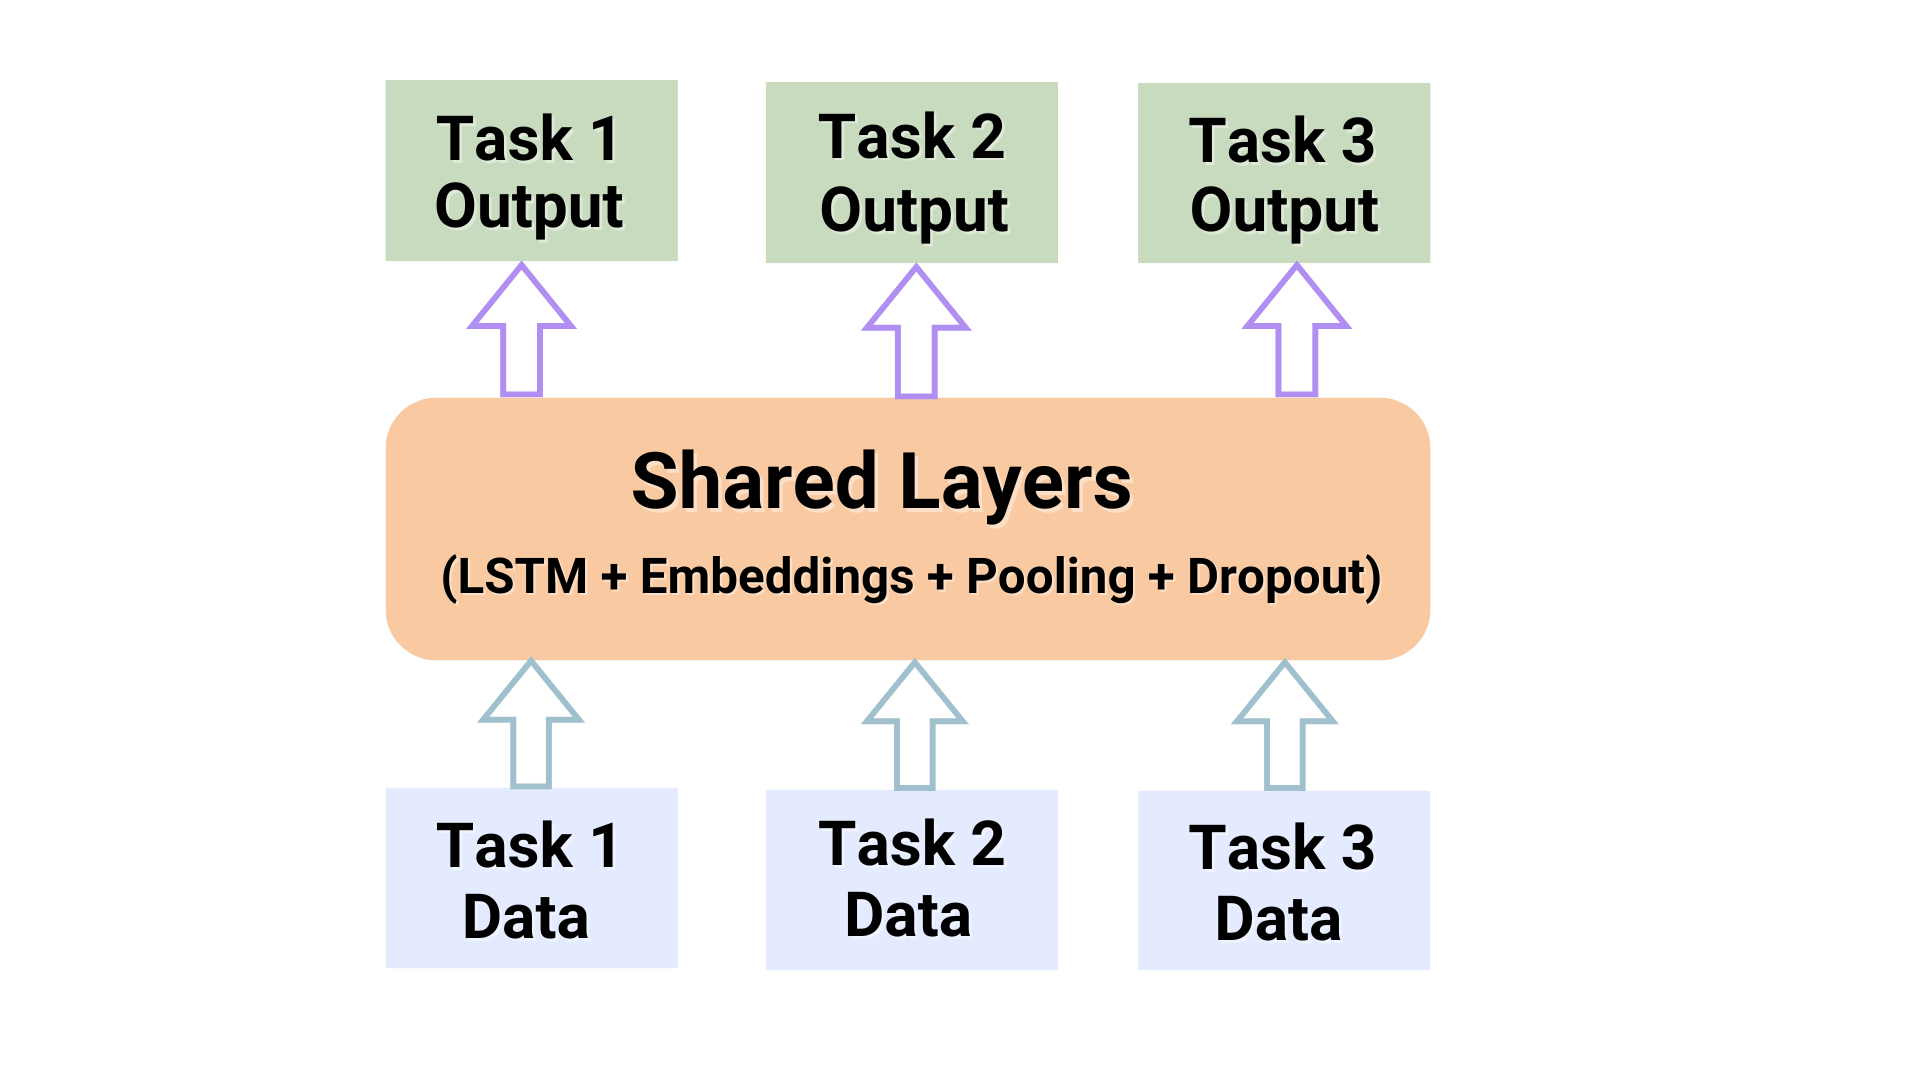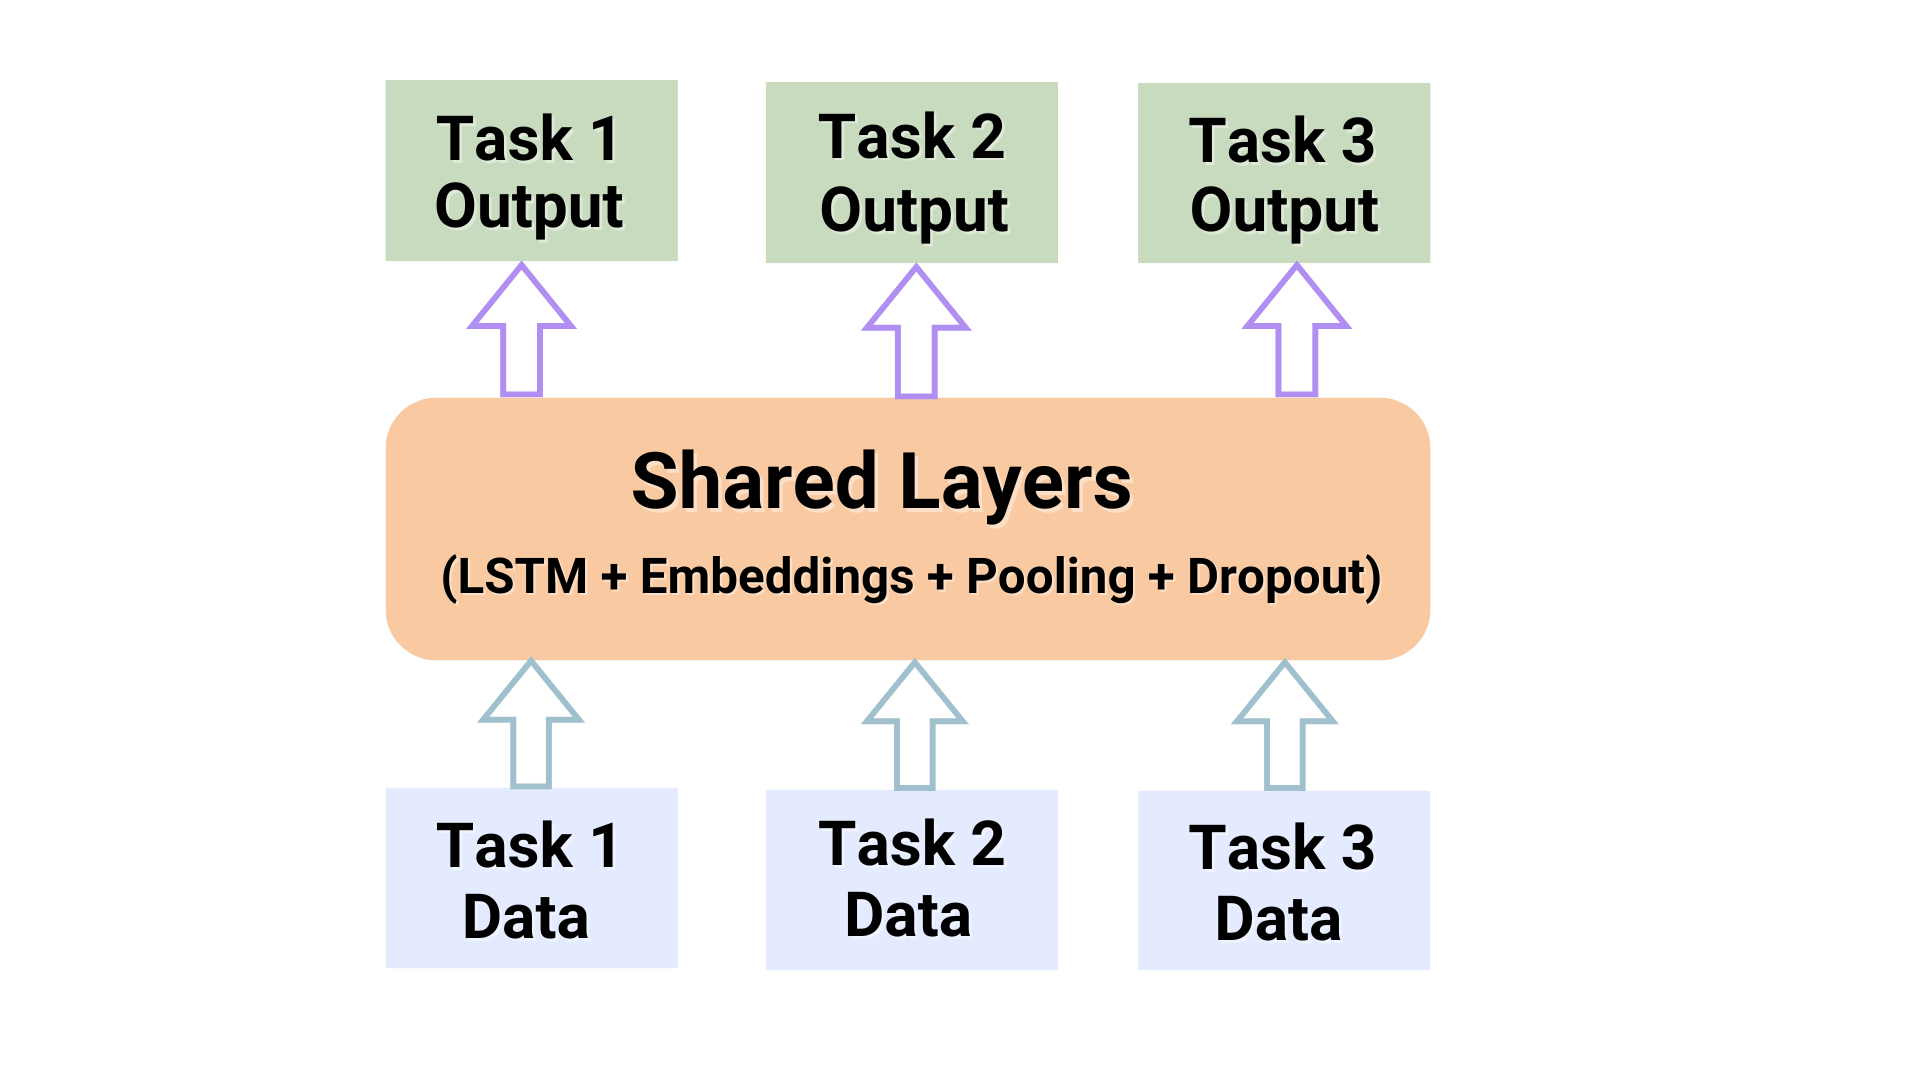

Emotions
0 : Sadness
1 : Joy
2 : Love
3 : Anger
4 : Fear
5 : Surprise

Violence
0 : Harmful_Traditional_practice
1 : Physical_violence
2 : economic_violence
3 : emotional_violence
4 : sexual_violence

Hate
0 : Hate Speech
1 : Offensive Speech
2 : Neitherpeech
2 : Neither

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
emotion_df = pd.read_csv('/kaggle/input/emotions/text.csv')
emotion_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
violence_df = pd.read_csv('/kaggle/input/gender-based-violence-tweet-classification/Train.csv')
violence_df.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [4]:
hate_df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
hate_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# DATA PREPROCESSING 

In [5]:
emotion_df.drop(columns = ['Unnamed: 0'], inplace = True)
violence_df.drop(columns = ['Tweet_ID'], inplace = True)
hate_df = hate_df[['tweet', 'class']]

In [6]:
emotion_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [7]:
violence_df.head()

,tweet,type
0,Had a dream i got raped last night. By a guy i...,sexual_violence
1,he thought the word raped means sex and told m...,sexual_violence
2,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,Chessy Prout can do better by telling the trut...,sexual_violence


In [8]:
hate_df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [9]:
emotion_df.columns, violence_df.columns, hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['tweet', 'type'], dtype='object'),
 Index(['tweet', 'class'], dtype='object'))

In [10]:
#RENAMING THE COLUMNS
violence_df.rename(columns = {'tweet': 'text', 'type': 'label'}, inplace = True)
hate_df.rename(columns = {'tweet': 'text', 'class': 'label'}, inplace = True)

In [11]:
emotion_df.columns, violence_df.columns, hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'))

In [12]:
emotion_df.isnull().sum(), violence_df.isnull().sum(), hate_df.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [13]:
emotion_df.shape, violence_df.shape, hate_df.shape

((416809, 2), (39650, 2), (24783, 2))

**TAKING 6000 ROWS FROM EACH DATAFRAME**

In [14]:
emotion_df['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [15]:
e_df = pd.DataFrame()
for i in range(6):
    subset = emotion_df[emotion_df['label'] == i].sample(n = 1000, random_state = 42)
    e_df = pd.concat([e_df, subset])

In [16]:
e_df.shape

(6000, 2)

In [17]:
emotion_df = e_df.copy()

In [18]:
emotion_df['label'].value_counts()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
Name: count, dtype: int64

In [19]:
violence_df['label'].value_counts()

label
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64

In [20]:
sexual_violence = violence_df[violence_df['label'] == 'sexual_violence'].sample(n = 2944, random_state = 42)
physical_violence = violence_df[violence_df['label'] == 'Physical_violence'].sample(n = 2000, random_state = 42)
violence_df = violence_df[violence_df['label'] != 'sexual_violence']
violence_df = violence_df[violence_df['label'] != 'Physical_violence']

In [21]:
violence_df.shape

(1056, 2)

In [22]:
violence_df = pd.concat([sexual_violence, violence_df], axis = 0)
violence_df = pd.concat([physical_violence, violence_df], axis = 0)

In [23]:
violence_df.shape

(6000, 2)

In [24]:
hate_df['label'].value_counts()

label
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [25]:
one_df = hate_df[hate_df['label'] == 1].sample(n = 2570, random_state = 42)
ontwo_df = hate_df[hate_df['label'] == 2].sample(n = 2000, random_state = 42)
hate_df = hate_df[hate_df['label'] != 1]
hate_df = hate_df[hate_df['label'] != 2]

In [26]:
one_df.shape

(2570, 2)

In [27]:
ontwo_df.shape

(2000, 2)

In [28]:
hate_df.shape

(1430, 2)

In [29]:
hate_df = pd.concat([one_df,hate_df], axis = 0)
hate_df = pd.concat([ontwo_df,hate_df], axis = 0)

In [30]:
hate_df.shape

(6000, 2)

In [31]:
emotion_df.shape, violence_df.shape, hate_df.shape

((6000, 2), (6000, 2), (6000, 2))

In [32]:
emotion_df.head(3)

,text,label
133243,ive learned to surround myself with women who ...,0
88501,i already feel crappy because of this and you ...,0
131379,i feel like i have lost mourned and moved past...,0


In [33]:
violence_df.head(3)

,text,label
15309,I’m the word person. My science husband beats ...,Physical_violence
24520,My Husband Beats Me - Housewife Runs To Court ...,Physical_violence
9722,I have this gnarly bruise on my forearm from g...,Physical_violence


In [34]:
hate_df.head(3)

,text,label
18754,RT @chicagotribune: Chicago will not refund $7...,2
21093,"Sometimes, even I gotta tell these hoes to gro...",2
1069,&#8216;Chillin&#8217; With My Homie Or What&#8...,2


**THE INDEXES ARE RANDOM THEY ARE NOT IN ORDER LIKE 0,1,2.... SO WE NEED TO MSKE MAKE THEM IN ORDER**

In [35]:
emotion_df.reset_index(drop = True, inplace = True)
violence_df.reset_index(drop = True, inplace = True)
hate_df.reset_index(drop = True, inplace = True)

In [36]:
emotion_df.head(3)

,text,label
0,ive learned to surround myself with women who ...,0
1,i already feel crappy because of this and you ...,0
2,i feel like i have lost mourned and moved past...,0


In [37]:
violence_df.head(3)

,text,label
0,I’m the word person. My science husband beats ...,Physical_violence
1,My Husband Beats Me - Housewife Runs To Court ...,Physical_violence
2,I have this gnarly bruise on my forearm from g...,Physical_violence


In [38]:
hate_df.head(3)

,text,label
0,RT @chicagotribune: Chicago will not refund $7...,2
1,"Sometimes, even I gotta tell these hoes to gro...",2
2,&#8216;Chillin&#8217; With My Homie Or What&#8...,2


# LABEL ENCODING

In [39]:
label_encoder = LabelEncoder()
violence_df['label'] = label_encoder.fit_transform(violence_df['label'])

In [40]:
violence_df.head(3)

,text,label
0,I’m the word person. My science husband beats ...,1
1,My Husband Beats Me - Housewife Runs To Court ...,1
2,I have this gnarly bruise on my forearm from g...,1


In [41]:
violence_df['label'].unique()

array([1, 4, 3, 0, 2])

# STOPWORDS REMOVAL

In [42]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
# LOADING THE STOPWORDS
stop_words = set(stopwords.words('english'))

In [44]:
len(stop_words)

179

In [45]:
def stopword_removal(text):
    all_words = nltk.word_tokenize(text)
    filtered_words = [word for word in all_words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [46]:
emotion_df['text'] = emotion_df['text'].apply(stopword_removal)
violence_df['text'] = violence_df['text'].apply(stopword_removal)
hate_df['text'] = hate_df['text'].apply(stopword_removal)

In [47]:
emotion_df.head()

,text,label
0,ive learned surround women lift leave feeling ...,0
1,already feel crappy upset situation doesnt help,0
2,feel like lost mourned moved past tears relati...,0
3,could write whole lot im feeling crappy dont t...,0
4,always seem feel inadequate,0


# TOKENIZATION AND PADDING

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([emotion_df['text'], violence_df['text'], hate_df['text']]))

In [49]:
emotion_seq = tokenizer.texts_to_sequences(emotion_df['text'])
violence_seq = tokenizer.texts_to_sequences(violence_df['text'])
hate_seq = tokenizer.texts_to_sequences(hate_df['text'])

In [50]:
emotion_df['text'].iloc[2]

'feel like lost mourned moved past tears relationship'

In [51]:
emotion_seq[2]

[1, 4, 317, 7835, 1124, 413, 1037, 356]

In [52]:
max_length = 50
emotion_padded = pad_sequences(emotion_seq, maxlen = max_length, padding = 'post')
violence_padded = pad_sequences(violence_seq, maxlen = max_length, padding = 'post')
hate_padded = pad_sequences(hate_seq, maxlen = max_length, padding = 'post')

In [53]:
emotion_padded[2]

array([   1,    4,  317, 7835, 1124,  413, 1037,  356,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [54]:
#GENERATING LABELS IN NUMPY ARRAY FORMAT
emotion_label = np.array(emotion_df['label'])
violence_label = np.array(violence_df['label'])
hate_label = np.array(hate_df['label'])

# MODEL DEFINATION

In [55]:
# PREPARE SEPERATE INPUTS FOR EACH DATASET
emotion_input = emotion_padded
violence_input = violence_padded
hate_input = hate_padded

In [56]:
#DEFINING MULTIPLE INPUT LAYERS
emotion_input_layer = keras.layers.Input(shape = (max_length,), name = 'emotion_input')
violence_input_layer = keras.layers.Input(shape = (max_length,), name = 'violence_input')
hate_input_layer = keras.layers.Input(shape = (max_length,), name = 'hate_input')

In [57]:
#SHARED EMBEDDING LAYER
embedding_layer = keras.layers.Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 128)

In [58]:
#APPLY THE EMBEDDING LAYER TO EACH INPUT
emotion_embedding = embedding_layer(emotion_input_layer)
violence_embedding = embedding_layer(violence_input_layer)
hate_embedding = embedding_layer(hate_input_layer)

In [59]:
#SHARED LSTM LAYER
shared_lstm = keras.layers.LSTM(64, return_sequences = True)

In [60]:
#APPLY THE LSTM LAYER TO EACH INPUT
emotion_lstm = shared_lstm(emotion_embedding)
violence_lstm = shared_lstm(violence_embedding)
hate_lstm = shared_lstm(hate_embedding)

In [61]:
#SHARED GLOBAL AVERAGE LAYER AN DROPOUT LAYER
shared_pooling = keras.layers.GlobalAveragePooling1D()
shared_dropout = keras.layers.Dropout(0.5)

In [62]:
emotion_features = shared_dropout(shared_pooling(emotion_lstm))
violence_features = shared_dropout(shared_pooling(violence_lstm))
hate_features = shared_dropout(shared_pooling(hate_lstm))

In [63]:
len(emotion_df['label'].unique()), len(violence_df['label'].unique()), len(hate_df['label'].unique())

(6, 5, 3)

In [64]:
#OUTPUT LAYERS
emotion_output = keras.layers.Dense(6, activation = 'softmax', name = 'emotion_output')(emotion_features)
violence_output = keras.layers.Dense(6, activation = 'softmax', name = 'violence_output')(violence_features)
hate_output = keras.layers.Dense(6, activation = 'softmax', name = 'hate_output')(hate_features)

In [65]:
#COMPILATION
model = keras.models.Model(inputs = [emotion_input_layer, violence_input_layer, hate_input_layer],
                           outputs = [emotion_output, violence_output, hate_output])

model.compile(optimizer = 'adam',
             loss = {
                 'emotion_output' : 'sparse_categorical_crossentropy',
                 'violence_output' : 'sparse_categorical_crossentropy',
                 'hate_output' : 'sparse_categorical_crossentropy'
             },
             metrics = {
                 'emotion_output' : 'accuracy',
                 'violence_output' : 'accuracy',
                 'hate_output' : 'accuracy'
             })

In [66]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  3,581,184 │ emotion_input[0]… │
│ (Embedding)         │                   │            │ violence_input[0… │
│                     │                   │            │ hate_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 64)    │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ lstm[0][0],       │
│ (GlobalAveragePool… │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        390 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 6)         │        390 │ dropout[1][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_output (Dense) │ (None, 6)         │        390 │ dropout[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,762 (13.85 MB)

 Trainable params: 3,631,762 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
#TRAINING THE MODEL WITH SEPERATE INPUTS
model.fit(x = {'emotion_input':emotion_input,
               'violence_input':violence_input,
               'hate_input':hate_input},
          y = {'emotion_output':emotion_label,
               'violence_output':violence_label,
               'hate_output':hate_label},
          epochs = 3,
          batch_size = 4)

Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - emotion_output_accuracy: 0.2086 - hate_output_accuracy: 0.4955 - loss: 3.5672 - violence_output_accuracy: 0.7476
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - emotion_output_accuracy: 0.6306 - hate_output_accuracy: 0.8347 - loss: 1.5554 - violence_output_accuracy: 0.9601
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - emotion_output_accuracy: 0.9064 - hate_output_accuracy: 0.9199 - loss: 0.6162 - violence_output_accuracy: 0.9971


# PREDICTION AND EVALUATION

In [68]:
prediction = model.predict({'emotion_input':emotion_input,
                           'violence_input':violence_input,
                           'hate_input':hate_input})

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [69]:
prediction

[array([[9.5143169e-01, 1.0852356e-02, 1.5095533e-04, 1.3350295e-02,
         1.3297150e-02, 1.0917557e-02],
        [9.9074441e-01, 2.6848661e-03, 1.4734978e-05, 4.1650324e-03,
         1.0791434e-03, 1.3118454e-03],
        [9.5866275e-01, 4.2035207e-03, 4.9374463e-05, 5.6773107e-03,
         1.1537479e-02, 1.9869702e-02],
        ...,
        [9.8609747e-03, 1.9205168e-03, 9.6506637e-04, 1.3277606e-03,
         1.3574941e-01, 8.5017616e-01],
        [7.7606752e-03, 1.7512050e-03, 1.2227223e-03, 2.6165827e-03,
         3.1985719e-02, 9.5466316e-01],
        [1.9938431e-03, 3.8563329e-04, 2.2749891e-04, 3.4669435e-04,
         1.6301349e-02, 9.8074490e-01]], dtype=float32),
 array([[7.6524620e-06, 9.9993998e-01, 4.8264806e-06, 5.1233283e-06,
         4.0749095e-05, 1.7211578e-06],
        [2.1449418e-06, 9.9997193e-01, 1.6641602e-06, 2.0433126e-06,
         2.1511747e-05, 6.8219538e-07],
        [8.2764900e-06, 9.9991375e-01, 6.8670283e-06, 6.7431797e-06,
         6.0962706e-05, 3.300

In [70]:
emotion_pred = np.argmax(prediction[0], axis = 1)
violence_pred = np.argmax(prediction[1], axis = 1)
hate_pred = np.argmax(prediction[2], axis = 1)

In [71]:
violence_df['label'].unique()

array([1, 4, 3, 0, 2])

**AS THE LABELS ARE NOT IN CORRECT ORDER SO WE HAVE TO CREATE A MAP TO DISPLAY THE LABEL IN WORDS**

In [72]:
def plot_cm(true, pred, title, labels):
    cf = confusion_matrix(true, pred, normalize = 'true')
    plt.figure(figsize = (7,6))
    sns.heatmap(cf, annot = True, cmap = 'Blues', xticklabels = labels, yticklabels = labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
hate_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

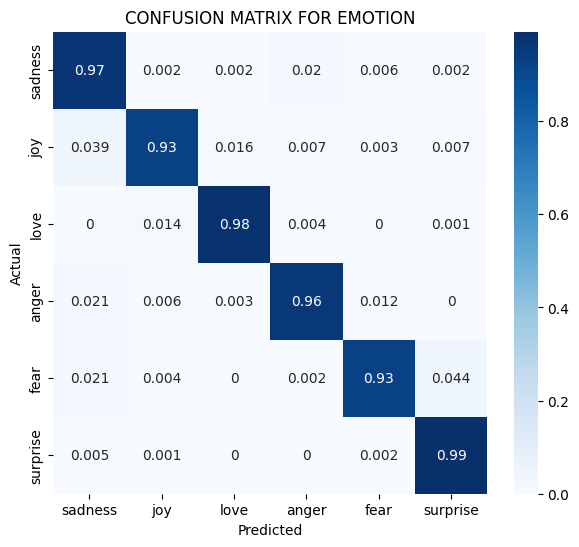

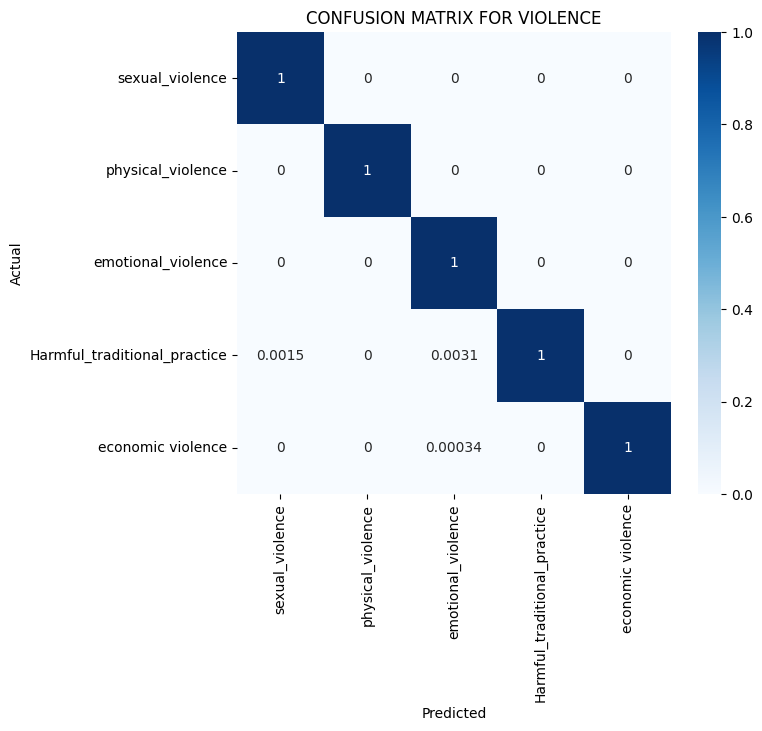

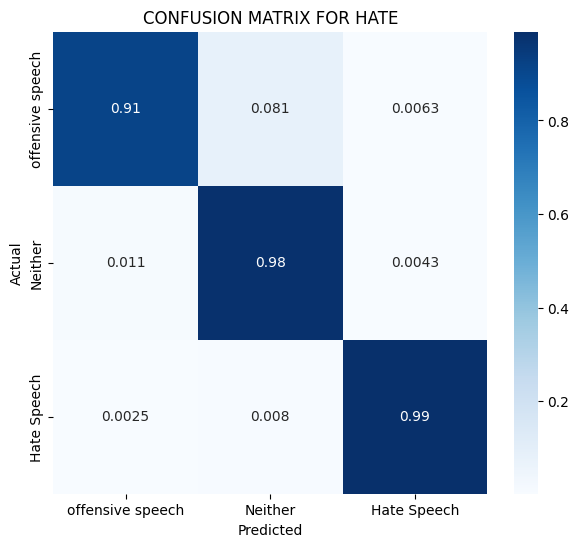

In [73]:
plot_cm(emotion_label, emotion_pred, 'CONFUSION MATRIX FOR EMOTION', emotion_labels_text)
plot_cm(violence_label, violence_pred, 'CONFUSION MATRIX FOR VIOLENCE', violence_labels_text)
plot_cm(hate_label, hate_pred, 'CONFUSION MATRIX FOR HATE', hate_labels_text)

# MANUAL TESTING

In [74]:
def classify_text(input_text):
    #PREPROCESS THE INPUT TEXT
    input_text_cleaned = remove_stopwords(input_text)
    input_sequence = tokenizer.texts_to_sequences([input_text_cleaned])
    input_padded = pad_sequences(input_sequence, maxlen = max_length, padding = 'post')
    #PREDICTION
    preictions = model.predict({'emotion_input': input_padded,
                                'violence_input' : input_padded,
                                'hate_input' : input_padded})
    emotion_pred = np.argmax(predictions[0], axis  =1)[0]
    violence_pred = np.argmax(predictions[1], axis  =1)[0]
    hate_pred = np.argmax(predictions[2], axis  =1)[0]
    #DETERMINE MAJOR LABEL
    major_labels = ['Emotion', 'Violence', 'Hate']
    major_label_index = np.argmax([np.max(predictions[0]), np.max(predictions[1]), np.max(predictions[2])])
    major_label = major_labels[major_label_index]
    #DETERMINING SUB LABELS
    emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
    hate_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

    if major_label == 'Emotion':
        sub_label = emotion_labels_text[emotion_pred]
    elif major_label == 'Violence':
        sub_label = violence_labels_text[violence_pred]
    else:
        sub_label = hate_labels_text[hate_pred]

    return major_label, sub_label

    

In [75]:
import ipywidgets as widgets
from IPython.display import display

In [76]:
input_text_widget = widgets.Text(
    description = 'Input text :',
    placeholder = 'Enter your text'
)

In [77]:
button = widgets.Button(description = 'classify')

In [78]:
output = widgets.Output()

In [79]:
#FUNCTION TO HANDLE EVENT
def on_button_click(b):
    with output:
        output.clear_output() #CLEAR THE PREV OUTPUT
        input_text = input_text_widget.value
        major_label, sub_label = classify_text(input_text)
        print(f'Major Label: {major_label}')
        print(f'Sub Label: {sub_label}')

#ATTACH BUTTON
button.on_click(on_button_click)

In [80]:
display(input_text_widget, button, output)

Text(value='', description='Input text :', placeholder='Enter your text')

Button(description='classify', style=ButtonStyle())

Output()